In [83]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import re
from collections import defaultdict
import random
import pandas as pd
from networkx.algorithms.community import louvain_communities
from wordcloud import WordCloud
import math
from sklearn.feature_extraction.text import TfidfVectorizer

url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/rock_network.gexf"

response = requests.get(url)
response.raise_for_status()

G = nx.read_gexf(BytesIO(response.content))
G_undirected = G.to_undirected()

---
# Part 1: Analyze the network
---

In this analysis, we explore a network of rock artists constructed from a list of "mainstream rock performers" from Wikipedia. Each artist is represented as a node, and directed links between artists are established when one artist is mentioned on another artist’s Wikipedia page. 

The graph has been stored in a .gexf file and fetched via a github link. 

When fetched here the nodes in the graph have the following attributes:
 - *Length of content*: the total word count of the artist’s Wikipedia page,
 - *Genres*: the musical genres listed in the artist’s infobox,
 - *Wikitext*: the cleaned text of the page.

In the following sections, we analyze both the directed and undirected versions of the network using concepts from network science.

The goal of this analysis is to characterize the structural properties of the network.

## General network statistics

We start the analysis by looking into 
 - Network size (nodes and edges)
 - Degree distributions (in/out for directed graphs)
 - Average shortest path length

In [84]:
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
n_edges_undir = G_undirected.number_of_edges()
density = 2 * n_edges / (n_nodes * (n_nodes - 1))

in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

avg_in = sum(in_degrees) / len(in_degrees)
avg_out = sum(out_degrees) / len(out_degrees)

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges in undirected graph: {n_edges_undir}")
print(f"Average degree of the undirected graph: {2 * G_undirected.number_of_edges() / G_undirected.number_of_nodes():.2f}")
print(f"Average in and out-degree:  {avg_in:.2f}")
print(f"Density of graph: {density}")

Number of nodes: 484
Number of edges: 7283
Number of edges in undirected graph: 5987
Average degree of the undirected graph: 24.74
Average in and out-degree:  15.05
Density of graph: 0.062308574166281674


We have 484 artists in our network with 7283 edges in the directed graph.
In the undirected version, there are only 5987 edges, meaning that in over 1000 cases, two artists link to each other. This is not surprising, as we would expect rock musicians who have collaborated to mutually refer to one another.

We can also conclude that in roughly 5000 cases, a Wikipedia page links to another without getting a link back.

We also note that about 6% of all possible node pairs are connected.

## In and out degrees

Next we look into the statistics concerning in and out degrees and the distribution of these.

In [85]:
print("\nIn-Degree Statistics:")
print(f"  Average: {np.mean(in_degrees):.2f}")
print(f"  Median: {np.median(in_degrees):.2f}")
print(f"  Mode: {Counter(in_degrees).most_common(1)[0][0]}")
print(f"  Min: {np.min(in_degrees)}")
print(f"  Max: {np.max(in_degrees)}")
print(f"  Std Dev: {np.std(in_degrees):.2f}")

print("\nOut-Degree Statistics:")
print(f"  Average: {np.mean(out_degrees):.2f}")
print(f"  Median: {np.median(out_degrees):.2f}")
print(f"  Mode: {Counter(out_degrees).most_common(1)[0][0]}")
print(f"  Min: {np.min(out_degrees)}")
print(f"  Max: {np.max(out_degrees)}")
print(f"  Std Dev: {np.std(out_degrees):.2f}")


In-Degree Statistics:
  Average: 15.05
  Median: 10.00
  Mode: 3
  Min: 0
  Max: 119
  Std Dev: 16.98

Out-Degree Statistics:
  Average: 15.05
  Median: 13.00
  Mode: 12
  Min: 0
  Max: 73
  Std Dev: 10.54


We can see that the in-degree varies more than the out-degree.

This can probably be explained by the fact that many artists refer to the larger, more well-known bands, which therefore have a high in-degree, while most bands only receive a few incoming links.

The out-degree varies less, which is propably because most bands tend to reference only a small number of other artists.

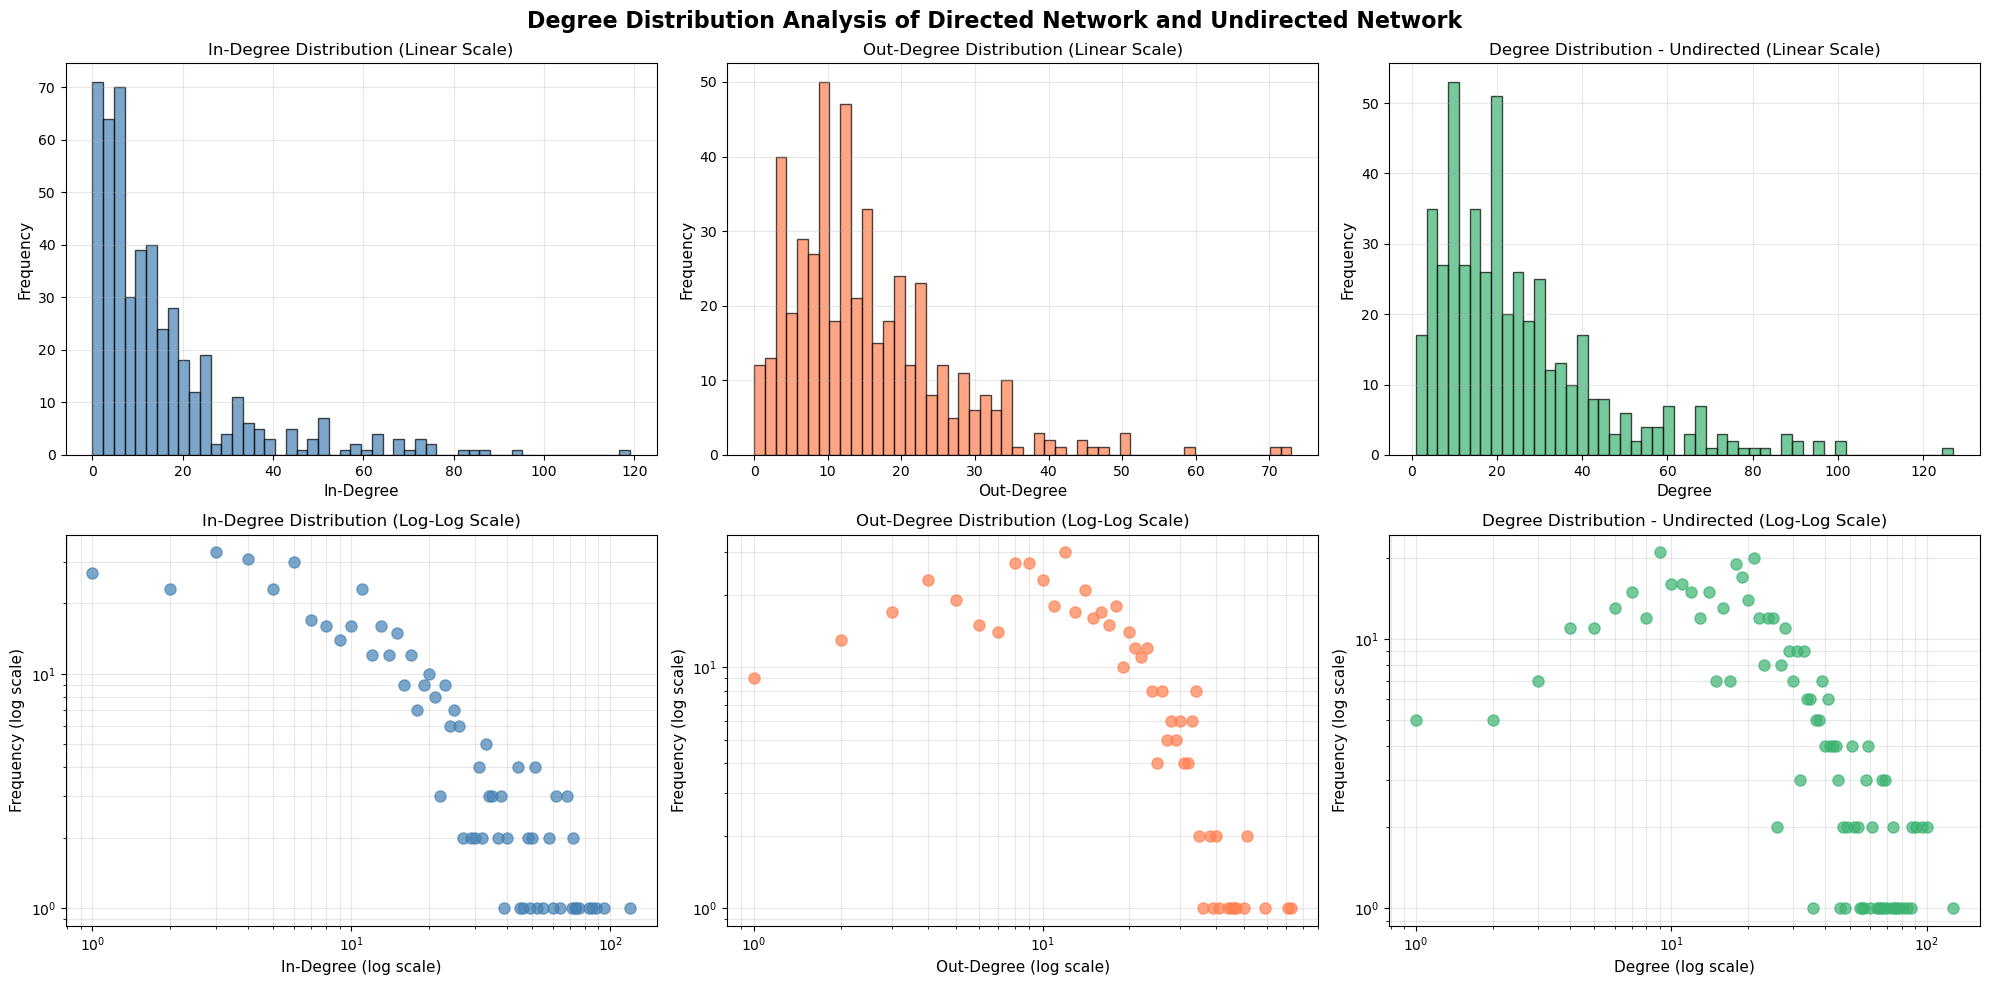

In [86]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Degree Distribution Analysis of Directed Network and Undirected Network', fontsize=16, fontweight='bold')
degrees = [d for n, d in G_undirected.degree()]

# In-degree distribution (linear scale)
axes[0, 0].hist(in_degrees, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('In-Degree', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('In-Degree Distribution (Linear Scale)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Out-degree distribution (linear scale)
axes[0, 1].hist(out_degrees, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Out-Degree', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Out-Degree Distribution (Linear Scale)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Undirected degree distribution (linear scale)
axes[0, 2].hist(degrees, bins=50, alpha=0.7, color='mediumseagreen', edgecolor='black')
axes[0, 2].set_xlabel('Degree', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('Degree Distribution - Undirected (Linear Scale)', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# In-degree distribution (log-log scale)
in_degree_counts = Counter(in_degrees)
degrees_in = sorted(in_degree_counts.keys())
counts_in = [in_degree_counts[d] for d in degrees_in]
axes[1, 0].loglog(degrees_in, counts_in, 'o', alpha=0.7, color='steelblue', markersize=8)
axes[1, 0].set_xlabel('In-Degree (log scale)', fontsize=11)
axes[1, 0].set_ylabel('Frequency (log scale)', fontsize=11)
axes[1, 0].set_title('In-Degree Distribution (Log-Log Scale)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, which='both')

# Out-degree distribution (log-log scale)
out_degree_counts = Counter(out_degrees)
degrees_out = sorted(out_degree_counts.keys())
counts_out = [out_degree_counts[d] for d in degrees_out]
axes[1, 1].loglog(degrees_out, counts_out, 'o', alpha=0.7, color='coral', markersize=8)
axes[1, 1].set_xlabel('Out-Degree (log scale)', fontsize=11)
axes[1, 1].set_ylabel('Frequency (log scale)', fontsize=11)
axes[1, 1].set_title('Out-Degree Distribution (Log-Log Scale)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, which='both')

# Undirected degree distribution (log-log scale)
degree_counts = Counter(degrees)
degree_vals = sorted(degree_counts.keys())
counts = [degree_counts[d] for d in degree_vals]
axes[1, 2].loglog(degree_vals, counts, 'o', alpha=0.7, color='mediumseagreen', markersize=8)
axes[1, 2].set_xlabel('Degree (log scale)', fontsize=11)
axes[1, 2].set_ylabel('Frequency (log scale)', fontsize=11)
axes[1, 2].set_title('Degree Distribution - Undirected (Log-Log Scale)', fontsize=12)
axes[1, 2].grid(True, alpha=0.3, which='both')


plt.tight_layout()


The plots above visualize the degree distributions for the in-degree, out-degree, and the undirected version of the network.

The in-degree distribution resembles a scale-free network, where most nodes have a low degree and a few nodes (the largest, most well-known bands) have a very high in-degree.

The out-degree distribution appears more similar to a random network, with degrees roughly normally distributed around 13.

The undirected degree distribution lies somewhere between these two patterns — it shows characteristics of both random and scale-free networks, but clearly has the long tail we know from scale-free networks.

## Centralities and assortativity

Next we examine the centrality and assortativity of the network

In [87]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G_undirected)

print(f"Average degree centrality:      {sum(degree_centrality.values())/len(degree_centrality):.4f}")
print(f"Average betweenness centrality: {sum(betweenness_centrality.values())/len(betweenness_centrality):.4f}")
print(f"Average eigenvector centrality: {sum(eigenvector_centrality.values())/len(eigenvector_centrality):.4f}")

assort = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity: {assort:.4f}")

Average degree centrality:      0.0623
Average betweenness centrality: 0.0036
Average eigenvector centrality: 0.0343
Degree assortativity: 0.0376


The average degree centrality is relatively low, indicating that most artists are directly connected to only a small fraction of the other artists in the network.

The quite low betweenness centrality indicates that only a few nodes act as important bridges, while most connections do not frequently lie on the shortest paths between others.

Similarly the relatively low eigenvector centrality shows that only a limited subset of artists are structurally influential, meaning that most artists are not strongly connected to other highly connected ones.

Finally, the low degree assortativity implies that the network is only weakly hierarchical — large and small bands tend to mix rather than forming separate clusters.

Next we plot the distribution of the centrality.

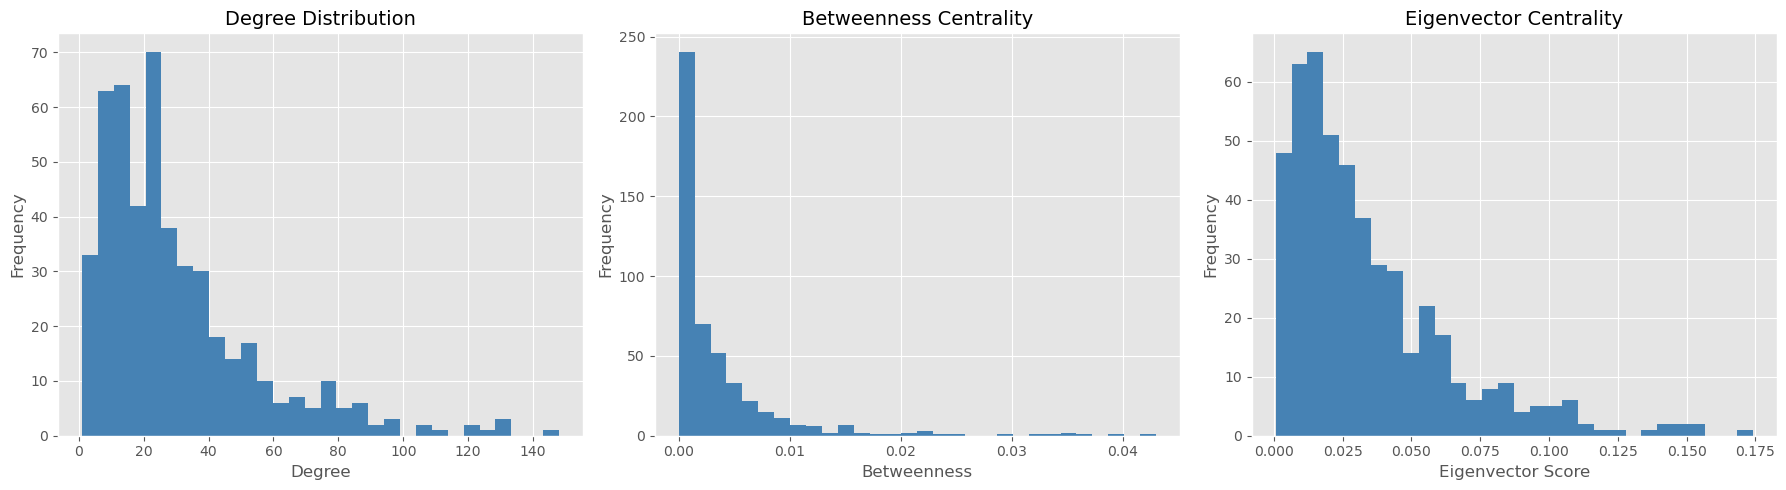

In [88]:
plt.style.use("ggplot")

degree_vals = [deg for _, deg in G.degree()]
betweenness_vals = list(betweenness_centrality.values())
eigenvector_vals = list(eigenvector_centrality.values())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
color = "steelblue"

# Degree
axes[0].hist(degree_vals, bins=30, color=color)
axes[0].set_title("Degree Distribution", fontsize=14)
axes[0].set_xlabel("Degree", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Betweenness
axes[1].hist(betweenness_vals, bins=30, color=color)
axes[1].set_title("Betweenness Centrality", fontsize=14)
axes[1].set_xlabel("Betweenness", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

# Eigenvector
axes[2].hist(eigenvector_vals, bins=30, color=color)
axes[2].set_title("Eigenvector Centrality", fontsize=14)
axes[2].set_xlabel("Eigenvector Score", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

Most nodes have a betweenness centrality close to zero and therefore do not play a central bridge role, as they rarely lie on the shortest paths between other nodes. Only a few nodes act as bridges connecting different clusters of the network. This means that only a few artists acts as links between different groups of artists.

Similarly, most nodes have low eigenvector centrality, meaning that they are mainly connected within small, less influential clusters. Some nodes fall in between, having moderate influence and a few connections to some more central parts of the network. Finally, a small number of nodes show high eigenvector centrality, indicating that they are connected to the most influential and well-connected parts of the network.

## Network visualization and backbone

Lastly, we wish to visualize our network. We plot both the full network and a reduced backbone version.

We start with the full undirected network:

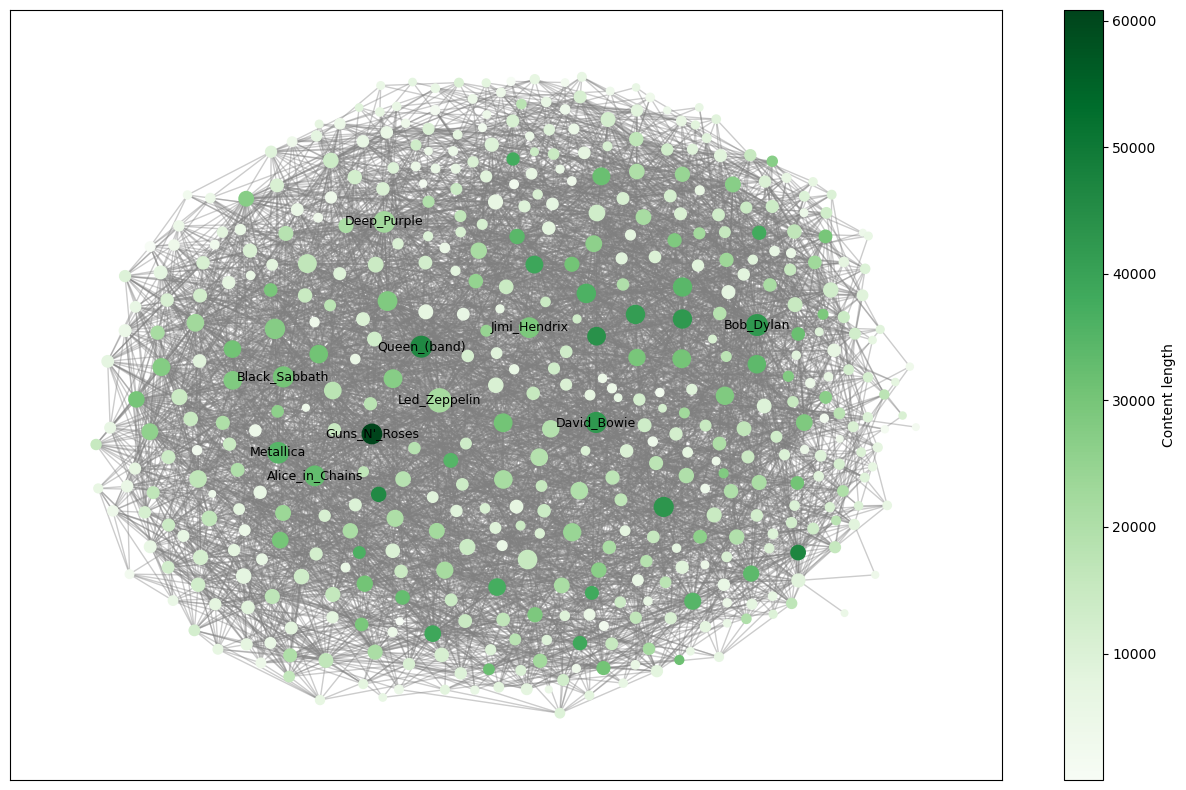

In [89]:
plt.style.use('default')

# Find node size
degrees = dict(G_undirected.degree())
node_sizes = [20 + deg * 2 for deg in degrees.values()] 

# Node colors
content_lengths = nx.get_node_attributes(G_undirected, "len_of_content")
node_colors = [content_lengths.get(n, 0) for n in G_undirected.nodes()]

pos = nx.forceatlas2_layout(G_undirected, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_undirected, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Greens, alpha=1)
nx.draw_networkx_edges(G_undirected, pos, edge_color="gray", alpha=0.4)

top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:10]
labels = {n: n for n in top_nodes}
nx.draw_networkx_labels(G_undirected, pos, labels, font_size=9, font_weight='normal') 

plt.colorbar(nodes, label="Content length")
plt.show()

The figure above shows the complete undirected network.

The size of each node represents its degree — the larger the node, the more connections the artist has.

The color of each node indicates the length of the artist’s Wikipedia page, with darker green corresponding to longer articles.

The 10 nodes with the highest degree are labeled by name in the plot, highlighting the most central and well-connected artists in the network.

To get a clearer visualization of the network, we create a backbone version of it.

We remove 85% of the edges by filtering out those with the lowest betweenness centrality, next removing any nodes that become isolated as a result.

This simplification highlights the most important structural connections in the network, making it easier to identify the central hubs and get an overall overview.

In [90]:
def backbone_low_betweenness(G_undirected, n_remove):
    # Work on a copy
    Gb = G_undirected.copy()

    # Compute edge betweenness
    ebc = nx.edge_betweenness_centrality(Gb)

    # Sort edges: lowest betweenness first
    edges_sorted = sorted(ebc.items(), key=lambda x: x[1])

    # Select lowest n_remove edges
    edges_to_remove = [edge for edge, score in edges_sorted[:n_remove]]

    # Remove edges
    Gb.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    isolated = list(nx.isolates(Gb))
    Gb.remove_nodes_from(isolated)

    return Gb


# --- Run ---
G_backbone = backbone_low_betweenness(G_undirected, n_remove=int(G_undirected.number_of_edges()*0.85))


print("Nodes:", G_backbone.number_of_nodes())
print("Edges:", G_backbone.number_of_edges())



Nodes: 440
Edges: 899


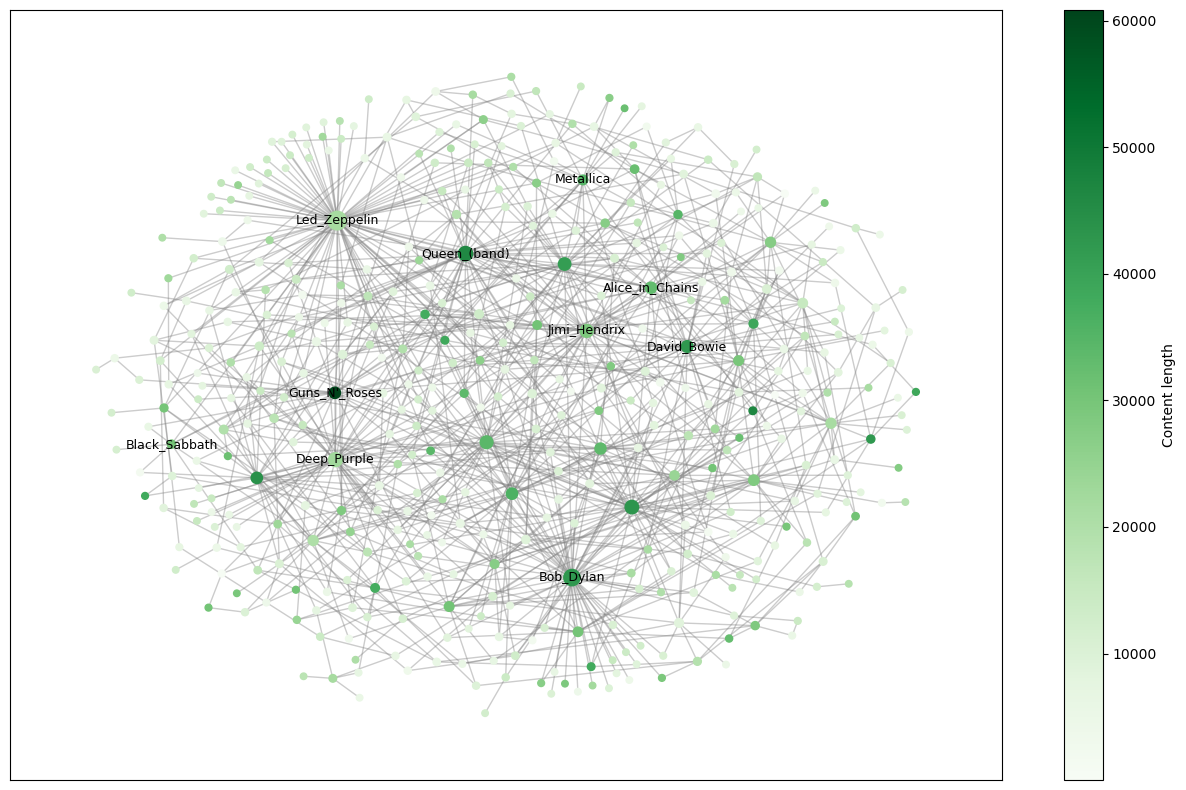

In [91]:
degrees_backbone = dict(G_backbone.degree())
backbone_node_sizes = [20 + deg * 2 for deg in degrees_backbone.values()]

backbone_content_lengths = nx.get_node_attributes(G_backbone, "len_of_content")
backbone_node_colors = [content_lengths.get(n, 0) for n in G_backbone.nodes()]

pos = nx.forceatlas2_layout(G_backbone, max_iter=500, scaling_ratio=2.0, gravity=1.0, strong_gravity=True, seed=30)

plt.figure(figsize=(16, 10))
nodes = nx.draw_networkx_nodes(G_backbone, pos, node_size=backbone_node_sizes, node_color=backbone_node_colors, cmap=plt.cm.Greens, alpha=1)
nx.draw_networkx_edges(G_backbone, pos, edge_color="gray", alpha=0.4)

top_nodes_backbone = sorted(degrees_backbone, key=degrees.get, reverse=True)[:10]
labels = {n: n for n in top_nodes_backbone}
nx.draw_networkx_labels(G_backbone, pos, labels, font_size=9, font_weight='normal')

plt.colorbar(nodes, label="Content length")
plt.show()

The backbone reveals a core of influential artists — such as Led Zeppelin, Queen, Metallica, Jimi Hendrix, and Bob Dylan — who act as hubs connecting different parts of the rock music. 

---
# Part 2: Genres and communities and plotting
---

Getting the undirected grahp and removing nodes without genre information

In [92]:
G = G.to_undirected()

nodes_without_genre = [node for node, data in G.nodes(data=True) if "genres" not in data or not data["genres"]]

G.remove_nodes_from(nodes_without_genre)
G.remove_nodes_from(list(nx.isolates(G)))

## Genres and modularity

We wish to partition the network into communities.

As a first approach, we use the genres listed for each artist as a predefined way of grouping them.
Since many artists are associated with multiple genres, we create two partitions:
one using the first listed genre, and one where we assign a random genre from the artist’s list.

We then calculate the modularity of each partition to evaluate how well these genre-based partitions align with the network’s actual community structure.

In [93]:
# Based on the first genre
genre_part = {}
for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres or not isinstance(genres, str):
        continue

    cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]

    if parts:
        genre_part[n] = parts[0] 

# Splitting into communities
genre_comm = defaultdict(list)
for node, genre in genre_part.items():
    genre_comm[genre].append(node)


# Based on a random genre
genre_part_random = {}

for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres or not isinstance(genres, str):
        continue

    cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]

    if parts:
        genre_part_random[n] = random.choice(parts)

# Splitting into communities
genre_comm_random = defaultdict(list)
for node, genre in genre_part_random.items():
    genre_comm_random[genre].append(node)


Computing the modularity:

In [94]:
# Function to calculate modularity
def Modularity(G, partition):
    if isinstance(partition, dict):
        communities = list(partition.values())
    else:
        communities = partition
    M = 0
    L = G.number_of_edges()
    deg = dict(G.degree())
    for nodes in communities:
        subG = G.subgraph(nodes)
        L_c = subG.number_of_edges()
        k_c = sum(deg[n] for n in nodes)
        M += (L_c / L) - (k_c / (2 * L)) ** 2
    return M

In [95]:
# Calculating number of links and nodes in each community and finding the sum
M = Modularity(G, genre_comm)
M_random = Modularity(G, genre_comm_random)

print(f"Modularity (first genre):  {M:.4f}")
print(f"Modularity (random genre): {M_random:.4f}")

Modularity (first genre):  0.0983
Modularity (random genre): 0.0337


The modularity values of both partitions are very low, indicating that grouping the network by genre does not produce a clear community structure.

This suggests that genre alone is too simplistic for partitioning the network. Other factors, such as the active years of the artist or the geographical origin, may play a more significant role in shaping the actual communities observed in the network.

## Communities and modularity

We now partition the network into communities based on the Louvain algorithm and compute the modularity in order to determine how well a partition it is.

In [96]:
louv_comm = louvain_communities(G, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = Modularity(G, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 6
Modularity (Louvain communities): 0.3311


We observe that the modularity is much higher when using the Louvain algorithm for partitioning.

This indicates that the Louvain method successfully detects communities that reflect the actual structure of the network.

We will use this partition — dividing the network into seven communities — for the subsequent analysis.

## Communities vs. genres

We compute the confusion matrix D to see if the detected communities overlap with the genres.

In [97]:
# Top 7 genres
all_genres = []
for _, data in G.nodes(data=True):
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if genres:
        all_genres.extend(genres)

# Biggest 7 communites
communities = sorted(louv_comm, key=len, reverse=True)
top_comms = communities[:7]

top_genres = [g for g, _ in Counter(all_genres).most_common(7)]
print("Top genres:", top_genres)
print("Top community sizes:", [len(c) for c in top_comms])

node_to_comm = {}
for j, comm in enumerate(top_comms):
    for n in comm:
        node_to_comm[n] = j

matrix = pd.DataFrame(0, index=top_genres, columns=[f"C{j}" for j in range(len(top_comms))])

for n, data in G.nodes(data=True):
    if n not in node_to_comm:
        continue 
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if not genres:
        continue
    for g in genres:
        if g in top_genres:
            matrix.loc[g, f"C{node_to_comm[n]}"] += 1

display(matrix)

Top genres: ['alternative rock', 'hard rock', 'pop rock', 'rock', 'alternative metal', 'blues rock', 'pop']
Top community sizes: [155, 92, 85, 72, 65, 4]


C0  C1  C2  C3  C4  C5
alternative rock    6  33  53   2  46   0
hard rock          16  20   7  53  43   0
pop rock           37  21  21  15  12   0
rock               69   0   9  13   2   1
alternative metal   0  26   1   0  33   0
blues rock         25   1   3  17   4   0
pop                40   2   5   2   1   0

The confusion matrix shows that the detected communities only partially align with the artists’ genres.

Most genres are distributed across several communities, indicating that genre alone does not fully explain the structure of the network.

However, certain patterns emerge — for example, hard rock and alternative metal are concentrated in community C4, while pop and rock appear more frequently in C0.

This suggests that while the Louvain algorithm captures some genre-based clustering, other factors also play an important role in shaping the network structure.

## Plot of the communities

Lastly we plot the network with the communities we detected colorcoded:

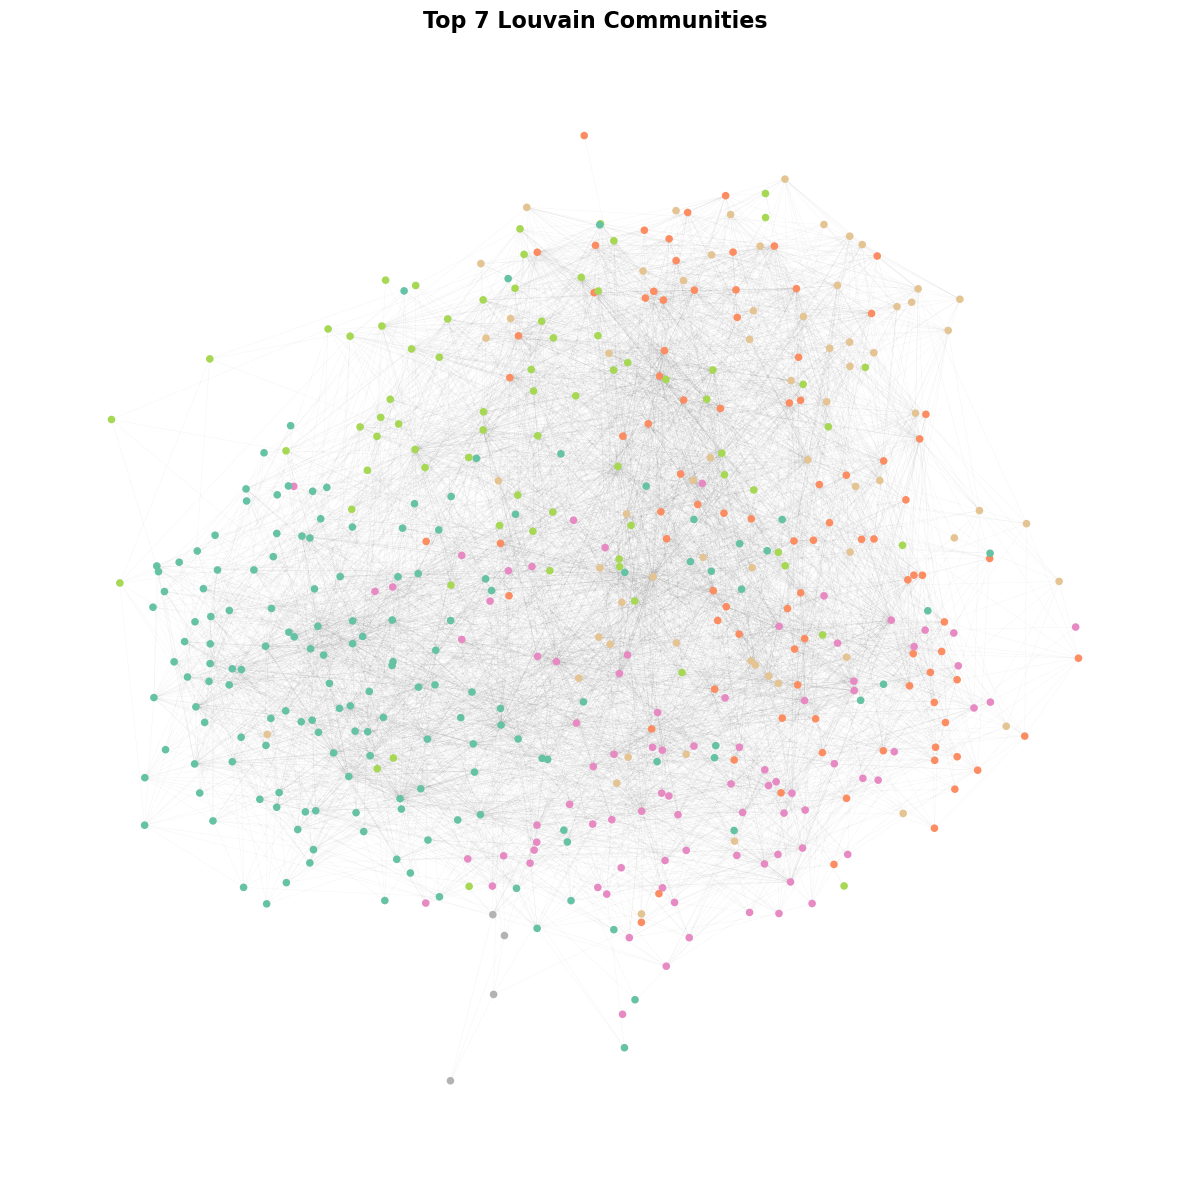

In [98]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=60)

top_nodes = set().union(*top_comms)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(top_comms)))
color_map = {}
for i, comm in enumerate(top_comms):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=30,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("Top 7 Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

Looking at the plot we can observe that there is some clustering of the community, but there is still very much overlap between the colors, suggesting that the network is highly interconnected, meaning the artists tend to connect accros many factors. 

The plot aligns with the modularity value of 0.33 which indicate that even though there is some community structure, their is also a lot of cross-community links.

---
# Part 3: TF-IDF to understand genres and communities
---

## Explain the concept of TF-IDF

TF-IDF is a method used to measure how frequent certain words are in a text while taking into account how common those words are in general. This means we look for words that appear more often in our text than expected in the language overall. It is used to extract information about what a text is about or which words are overrepresented. For example, if the words are very positive, it is probably a happy text; if the words are very complex, the text is likely aimed at a higher level. It might also reveal many words from a specific genre, suggesting that the text focuses on that.

In our case, we would expect words like rock, music, and band to be frequent. These terms may not tell us much about different communities, but words such as thrash, riff, and Metallica may be more represented in metal than in other genres. Therefor we can look into the words that differ in the diffrent genre. This is useful for our analysis because it can give us insight into what the Wikipedia pages focus on.

In [99]:
top_genres = [g for g, _ in Counter(all_genres).most_common(15)]
texts_by_genre = defaultdict(list)

for node, data in G.nodes(data=True):
    text = data.get("wikitext")
    genres_str = data.get("genres") 
    if genres_str:
        genres_list = [g.strip().lower() for g in genres_str.split(",")]
        for g in genres_list:
            if g in top_genres: 
                texts_by_genre[g].append(text)




genre_docs = {g: " ".join(texts_by_genre[g]) for g in top_genres}

custom_stopwords = [
    "band", "album", "song", "music", "released", "years", "group", "artist",
    "record", "studio", "single", "tracks", "performed", "songs", "recorded",
    "label", "band's", "rock", "tour", "category", "new", "number", "time"
]

vectorizer = TfidfVectorizer(
    stop_words='english',  
    max_features=5000
)

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords + list(vectorizer.get_stop_words()),
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform([genre_docs[g] for g in top_genres])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=top_genres,
    columns=vectorizer.get_feature_names_out()
)

tfidf_df.head()

### for comunities

texts_by_comm = {}

for i, comm in enumerate(top_comms):
    all_text = []

    for node in comm:
        text = G.nodes[node].get("wikitext", "")
        if text:
            all_text.append(text)

    texts_by_comm[f"community_{i}"] = " ".join(all_text)


docs = list(texts_by_comm.values())
comm_names = list(texts_by_comm.keys())


vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords + list(vectorizer.get_stop_words()),
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
tfidf_df_comm = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=comm_names,
    columns=vectorizer.get_feature_names_out()
)




In [100]:
top_words_genre = {}

for genre in top_genres:
    sorted_words = tfidf_df.loc[genre].sort_values(ascending=False)
    top_words_genre[genre] = sorted_words.head(10)
    print(f"\n--- {genre} ---")
    print(top_words_genre[genre])


top_words_comm = {}

for comm in comm_names:
    sorted_words = tfidf_df_comm.loc[comm].sort_values(ascending=False)
    top_words_comm[comm] = sorted_words.head(10)
    print(f"\n--- {comm} ---")
    print(top_words_comm[comm])



--- alternative rock ---
best         0.157681
live         0.140800
year         0.138442
guitar       0.131558
video        0.127785
awards       0.125711
release      0.125522
announced    0.117883
vocals       0.115620
records      0.109961
Name: alternative rock, dtype: float64

--- hard rock ---
live         0.160644
guitar       0.158852
vocals       0.146602
lead         0.124193
year         0.121604
musical      0.119811
albums       0.118018
announced    0.117122
release      0.110649
records      0.110250
Name: hard rock, dtype: float64

--- pop rock ---
vocals      0.173099
best        0.146616
year        0.136986
live        0.135422
guitar      0.134940
uk          0.125912
american    0.119412
records     0.113754
albums      0.111828
awards      0.110263
Name: pop rock, dtype: float64

--- rock ---
guitar      0.153435
american    0.148964
year        0.131079
vocals      0.129880
records     0.126826
live        0.123446
uk          0.119956
later       0.115703
bes

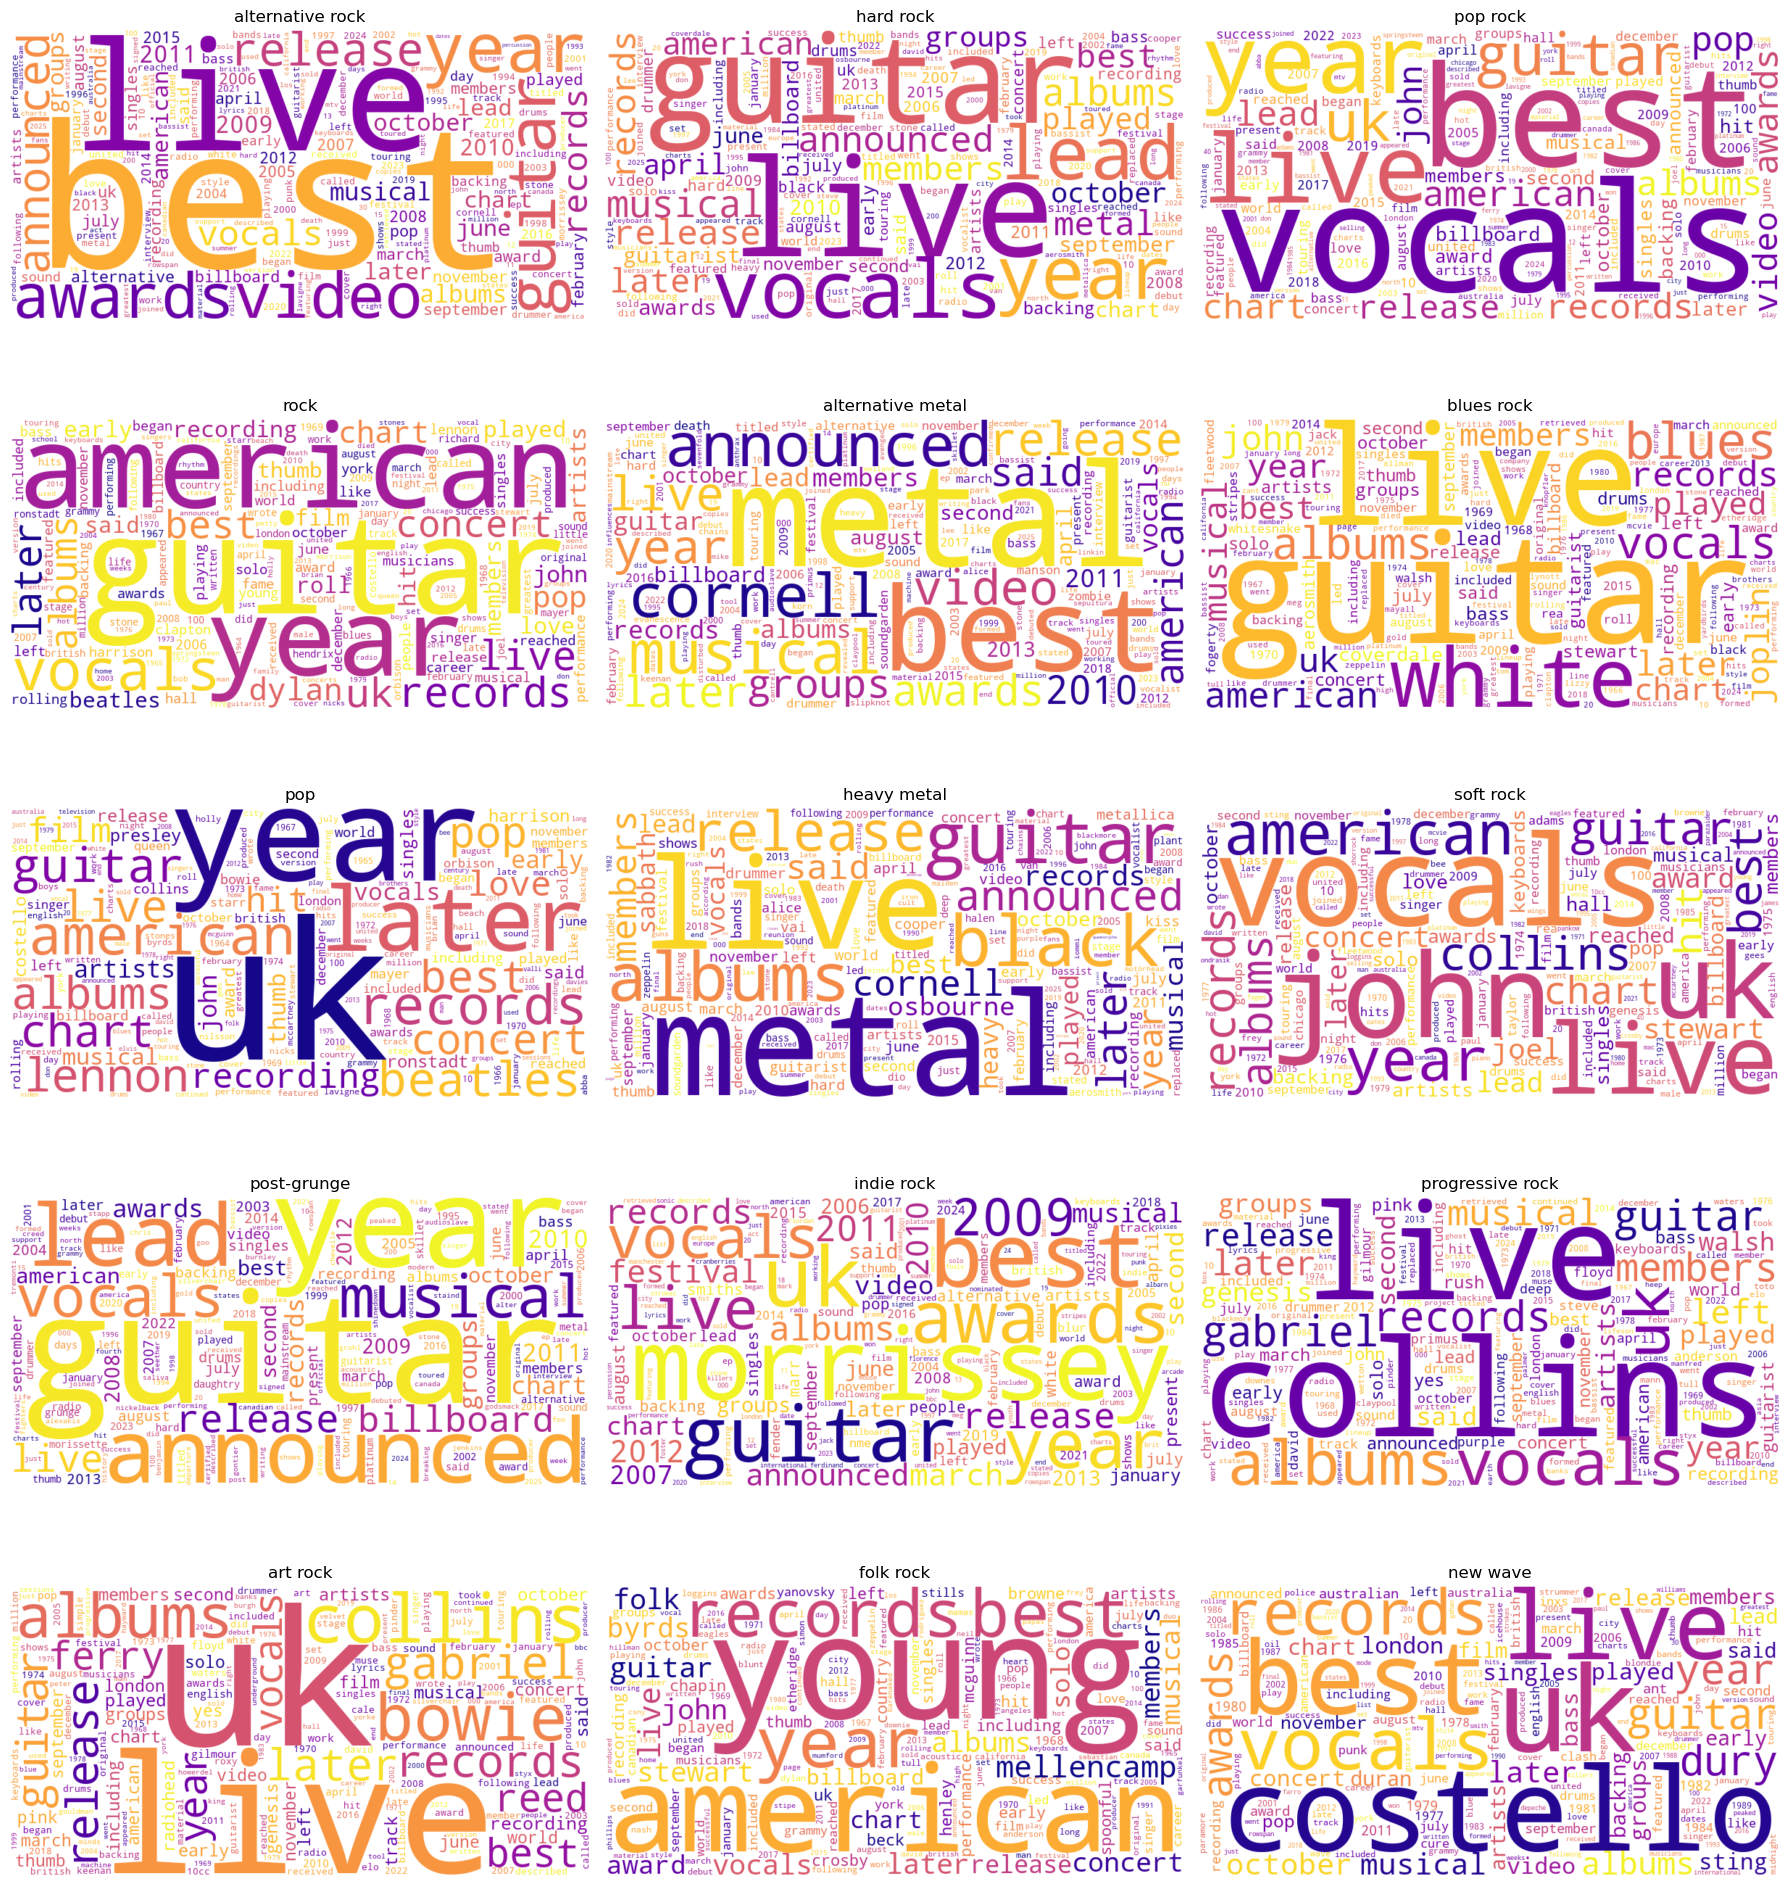

In [101]:
n = len(top_genres)
cols = 3  # number of columns
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*6, rows*4))

for i, genre in enumerate(top_genres):
    scores = tfidf_df.loc[genre]
    scaled_scores = scores / scores.max()  # scale 0–1

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',  # white background
        colormap='plasma',         # change colors
    ).generate_from_frequencies(scaled_scores.to_dict())

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(genre, fontsize=12)

plt.tight_layout()
plt.show()


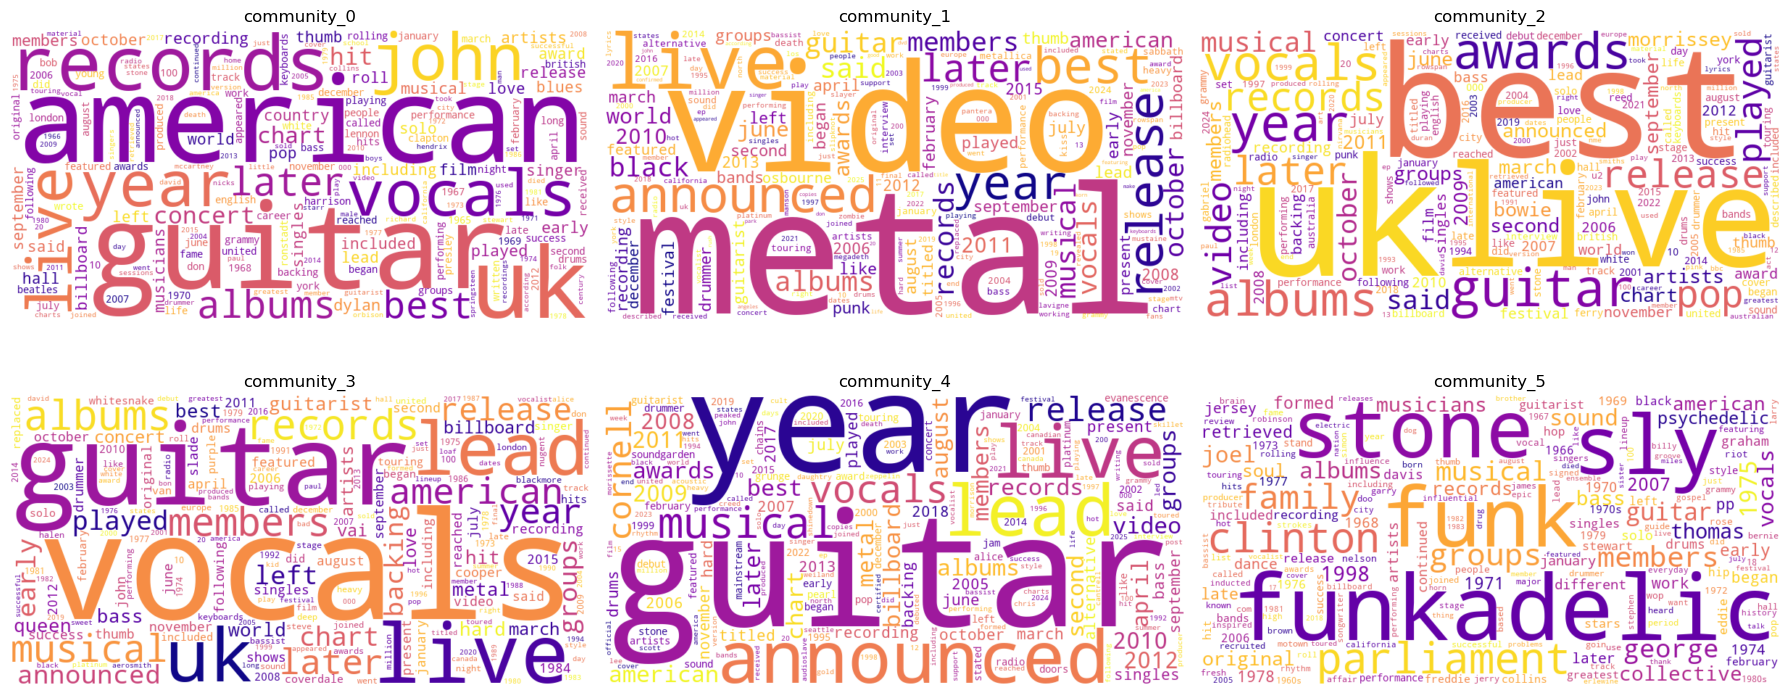

In [102]:

n = len(comm_names)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*6, rows*4))

for i, comm in enumerate(comm_names):
    scores = tfidf_df_comm.loc[comm]
    scaled_scores = scores / scores.max()  # 0–1 scaling

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='plasma'
    ).generate_from_frequencies(scaled_scores.to_dict())

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(comm, fontsize=12)

plt.tight_layout()
plt.show()

We chose to look at which words appear more frequently than expected in the English language, and then removed certain common words (stopwords) that appear across most of our Wikipedia pages, such as band, album, song, and music. We removed these because they do not provide useful information about differences between the genres or between the different communities. 

## Matrix D compared to word-clouds between genres and communities.

From the matrix D, we can see that a large portion of the musicians in community 0 have rock as their genre. This aligns with the fact that both community 0 and rock have America and guitar as frequent words.
It is also clear that metal is a common word in both community 1 and alternative metal, which matches the observation that alternative rock makes up a significant part of community 1.
There are many more examples like this, where we can reasonably guess which community the majority of a genre will belong to

---
# Part 4: Sentiment of the artists and communities
---

We first fetch the LabMT wordlist:

In [103]:
labmt_url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/Data_Set_S1.txt"

response_labmt = requests.get(labmt_url)
response_labmt.raise_for_status()

labmt = pd.read_csv(BytesIO(response_labmt.content), sep="\t", skiprows=2)
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))

We wish to be able to determine the sentiment of a text based on the word list from LabMT.

First we make a function to calculate the sentiment:

In [104]:
def calc_sentiment(tokens):
    scores = []
    for token in tokens:
        token = token.lower()
        if token in labmt_dict:
            scores.append(labmt_dict[token])
    if scores:
        return np.mean(scores)
    else:
        return None

This function can then be used to calculate the wikipediapage of each artist on the list.

We add the sentiment as an attribute to the nodes.

In [105]:
for node, data in G.nodes(data=True):
    text = data.get("wikitext")
    if not text:
        continue
    tokens = re.findall(r"\w+", text.lower())
    sentiment = calc_sentiment(tokens)
    G.nodes[node]["sentiment"] = sentiment

We plot the calculated sentiments in a histogram:

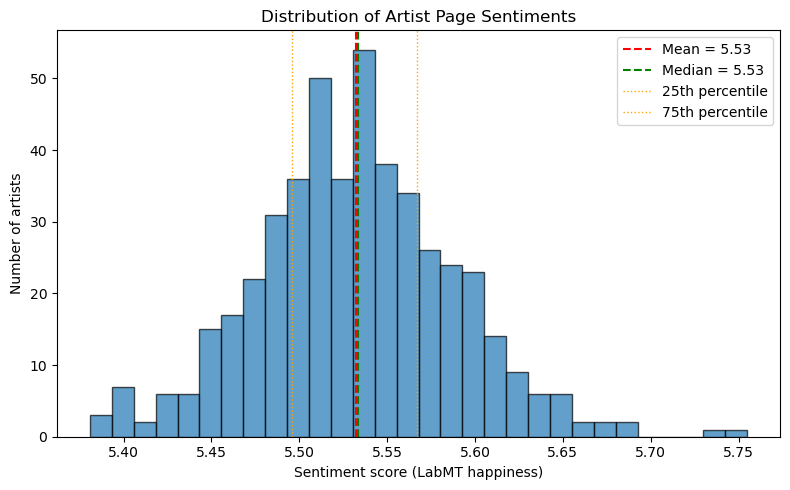

Variance: 0.0032


In [106]:
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes() if not np.isnan(G.nodes[n]["sentiment"])]

mean_sent = np.mean(sentiments)
median_sent = np.median(sentiments)
var_sent = np.var(sentiments)
p25 = np.percentile(sentiments, 25)
p75 = np.percentile(sentiments, 75)

plt.figure(figsize=(8,5))
plt.hist(sentiments, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_sent, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_sent:.2f}")
plt.axvline(median_sent, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_sent:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Artist Page Sentiments")
plt.xlabel("Sentiment score (LabMT happiness)")
plt.ylabel("Number of artists")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Variance: {var_sent:.4f}")

The sentiment scores for the artists’ Wikipedia pages is distributed normally and centered around a mean of 5.53.

This indicates that the language used in most articles is generally neutral with very little variation across artists, which can be seen by the very small variance.

The small range suggests that there are no strong outliers and that the sentiment is relatively consistent across the dataset.

## Community level sentiment

Next we calculate the sentiments on a community level using our sentiment calculater function from earlier.

In [107]:
comm_sentiments = {}

for name, text in texts_by_comm.items():
    tokens = re.findall(r"\w+", text.lower())
    sentiment = calc_sentiment(tokens)
    comm_sentiments[name] = sentiment

We compile the results into a single dataframe that summarizes each community.

For every community, we list the three most connected artists (based on degree centrality), the most dominant genres within the group, and the average sentiment value calculated from the artists’ Wikipedia pages.

In [108]:
deg_cent = nx.degree_centrality(G)

community_info = []

for i, comm in enumerate(louv_comm):
    comm_deg = {n: deg_cent[n] for n in comm}
    top3 = sorted(comm_deg.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_names = [n.replace("_", " ") for n, _ in top3]

    all_genres = []
    for node in comm:
        g = G.nodes[node].get("genres")
        if isinstance(g, str):
            parts = [p.strip().lower() for p in re.split(r",|;|\s{2,}", g) if p.strip()]
            all_genres.extend(parts)
    common_genres = [g for g, _ in Counter(all_genres).most_common(1)]

    community_info.append({
        "Community": f"C{i}",
        "Top bands": ", ".join(top3_names),
        "Top genres": ", ".join(common_genres),
    })

community_df = pd.DataFrame(community_info)
sentiment_values = list(comm_sentiments.values())
community_df["Sentiment"] = sentiment_values
community_df

Community                                          Top bands  \
0        C0  Sly and the Family Stone, Funkadelic, Parliame...   
1        C1            Queen (band), Deep Purple, Alice Cooper   
2        C2                Bob Dylan, Jimi Hendrix, Elton John   
3        C3                    David Bowie, U2, Nirvana (band)   
4        C4           Led Zeppelin, Alice in Chains, Pearl Jam   
5        C5            Metallica, Black Sabbath, Guns N' Roses   

         Top genres  Sentiment  
0         funk rock   5.528768  
1         hard rock   5.501681  
2              rock   5.540685  
3  alternative rock   5.512461  
4  alternative rock   5.538975  
5  alternative rock   5.505230

As expected the sentiments on a community level is also in a very narrow range. This again makes sence since the sentiment is calculated from wikipedia pages, hence ideally they a written in a neutral and objective language.

That being said there is still some difference in the sentiments. From the overview we see that community 3 have the highest sentiment and if we look at the wordcloud for this specific community we can also see that there are some positive words defining that community, e.g. "best", "awards" and "live", whereas in community 6 which have the lowest sentiment value we see more words with a neutral sentiment value such as "james", "hit" and "record":

In [109]:
print(f"Sentiment values for the words 'best', 'awards' and 'live': {labmt_dict["best"]}, {labmt_dict["awards"]} and {labmt_dict["live"]}")
print(f"Sentiment values for the words 'james', 'hit' and 'record': {labmt_dict["james"]}, {labmt_dict["hit"]} and {labmt_dict["record"]}")


Sentiment values for the words 'best', 'awards' and 'live': 7.18, 7.18 and 6.84
Sentiment values for the words 'james', 'hit' and 'record': 5.28, 4.58 and 5.78
